# 🧬 Proteoclock: Predicting Biological Age from Protein Data

Welcome to the **Proteoclock** demonstration! This notebook will take you on a journey through the fascinating world of protein-based aging clocks.

## 🎯 What You'll Learn
- **Prediction**: Use multiple approaches to predict biological age from protein measurements
- **Analysis**: Compare how different clocks perform and what they reveal about aging


## 📦 Setup and Imports

Let's start by importing everything we need and setting up our visualization style.

In [1]:
# Core libraries
import numpy as np
import pandas as pd
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Analysis tools
from sklearn.metrics import r2_score, mean_absolute_error
from scipy import stats
import pickle

# All supported clocks are avaialble through the dedicated factory class
# This pacakage comes with some mock data to give you a better idea of the accepted format
from proteoclock import ClockFactory, load_test_age_data, load_test_protein_data

# Make our plots beautiful
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams.update({
    'figure.figsize': (8, 6),
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'font.size': 12
})

print("🎉 All libraries loaded successfully!")
print("Ready to explore the fascinating world of protein-based aging clocks!")

🎉 All libraries loaded successfully!
Ready to explore the fascinating world of protein-based aging clocks!


## 🔍 Step 1: Discovering Available Aging Clocks

The proteoclock library contains multiple aging clocks developed by different research groups. Let's see what's available!

In [2]:
# Initialize our clock factory and view all available options
print("🏭 Initializing ClockFactory...")
factory = ClockFactory()

print("\n" + "="*60)
print("🕐 AVAILABLE AGING CLOCKS")
print("="*60)
factory.view_clocks()

🏭 Initializing ClockFactory...

🕐 AVAILABLE AGING CLOCKS
Available Aging Clocks:

Simple Clocks:
--------------------
  goeminne_2025:
    full_chrono:
      - 1 conventional, 18 organ-specific
      - Organs: adipose, adreanal, artery, brain, esophagus, ... (13 more)
    reduced_chrono:
      - 1 conventional, 17 organ-specific
      - Organs: adipose, adreanal, artery, brain, esophagus, ... (12 more)
    reduced_mortality:
      - 1 conventional, 17 organ-specific
      - Organs: adipose, adreanal, artery, brain, esophagus, ... (12 more)
    full_mortality:
      - 1 conventional, 18 organ-specific
      - Organs: adipose, adreanal, artery, brain, esophagus, ... (13 more)
  kuo_2024:
    - 1 conventional clock(s)

Deep Learning Clocks:
-------------------------
  galkin_2025


### 🎯 Understanding Clock Types

**Simple Clocks**: Linear models trained on specific datasets
- **Kuo 2024**: Mortality-linked model, requires known age labels
- **Goeminne 2025**: Multiple variants (chronological and mortality-linked) with organismal and organ-specific versions

**Deep Learning Clocks**: Neural networks with advanced architectures
- **Galkin 2025**: Transformer-based model with attention mechanisms

Let's explore the Goeminne clock variants in detail:

In [3]:
print("🔬 DETAILED LOOK AT GOEMINNE 2025 VARIANTS")
print("="*50)
factory.view_clock_variants("goeminne_2025")

print("\n💡 Key Insights:")
print("   • 'full' vs 'reduced': Different protein sets (full includes more proteins)")
print("   • 'chrono' vs 'mortality': Trained to predict chronological age vs death risk")
print("   • Organ-specific: Specialized for tissue-specific aging patterns")

🔬 DETAILED LOOK AT GOEMINNE 2025 VARIANTS
Variants for goeminne_2025:

full_chrono:
  Conventional clocks: 1
  Organ-specific clocks: 18
  Available organs: adipose, adreanal, artery, brain, esophagus, heart, immune, intestine, kidney, liver, lung, muscle, pancreas, pituitary, salivary, skin, stomach, thyroid
  Weight files: 19
    - gladyshev_pituitary_1st_gen.txt
    - gladyshev_salivary_1st_gen.txt
    - gladyshev_adipose_1st_gen.txt
    ... and 16 more

reduced_chrono:
  Conventional clocks: 1
  Organ-specific clocks: 17
  Available organs: adipose, adreanal, artery, brain, esophagus, heart, immune, intestine, kidney, liver, lung, muscle, pancreas, pituitary, salivary, skin, stomach
  Weight files: 18
    - gladyshev_adipose_1st_gen_r.txt
    - gladyshev_esophagus_1st_gen_r.txt
    - gladyshev_heart_1st_gen_r.txt
    ... and 15 more

reduced_mortality:
  Conventional clocks: 1
  Organ-specific clocks: 17
  Available organs: adipose, adreanal, artery, brain, esophagus, heart, immune

### 🧪 Data Normalization: The Importance of Scalers

You can try different ways to scale the data to see if this yields you any gain in accuracy.
Goeminne scalers are recommended if non-Olink platforms are used ([see the docs](https://github.com/ludgergoeminne/organAging/tree/main)).

Scalers are loaded before invoking the predictors. At prediction time you may select between `"standard"` and `"minmax"` scaling modes. There's also `None` set as default, of course

In [4]:
print("⚖️  AVAILABLE DATA SCALERS")
print("="*40)
factory.view_clock_scalers("goeminne_2025")

⚖️  AVAILABLE DATA SCALERS
Available Scalers:

Suggested scalers for goeminne_2025:
  - goeminne_2025_full
  - goeminne_2025_reduced

All available scalers:
  - goeminne_2025_full
  - goeminne_2025_reduced
  - ukb_scaler


## 🚀 Step 2: Creating Our Aging Clock Arsenal

Let's initialize different types of clocks to see how they compare!

In [5]:
print("🔧 INITIALIZING AGING CLOCKS...")
print("="*40)

# Simple linear clock
print("⚡ Loading Kuo 2024 (Gompertz mortality-linked model)...")
kuo_clock = factory.get_clock("kuo_2024", scaler="ukb_scaler")

# Organ-specific chronological age clock
print("🫀 Loading Goeminne 2025 - Liver-specific chronological clock...")
goem_liver = factory.get_clock("goeminne_2025_full_chrono", subtype="liver", scaler="goeminne_2025_full")

# Conventional mortality-focused clock
print("💀 Loading Goeminne 2025 - Mortality-linked clock...")
goem_mortality = factory.get_clock("goeminne_2025_reduced_mortality", scaler="goeminne_2025_reduced")

# Deep learning model
print("🧠 Loading Galkin 2025 (Deep Learning Transformer)...")
galkin_clock = factory.get_clock("galkin_2025")

print("\n✅ All clocks loaded successfully!")
print("Ready to predict biological ages! 🎯")

🔧 INITIALIZING AGING CLOCKS...
⚡ Loading Kuo 2024 (Gompertz mortality-linked model)...
🫀 Loading Goeminne 2025 - Liver-specific chronological clock...
💀 Loading Goeminne 2025 - Mortality-linked clock...
🧠 Loading Galkin 2025 (Deep Learning Transformer)...

✅ All clocks loaded successfully!
Ready to predict biological ages! 🎯


## 📊 Step 3: Loading and Exploring Sample Data

Let's load some real protein data and see what we're working with.

In [6]:
print("📥 LOADING SAMPLE DATA...")
print("="*30)

# Load the sample datasets
# The data is artificial and does not represent any actual human samples
age_data = load_test_age_data()
protein_data = load_test_protein_data()

print(f"👥 Loaded data for {len(age_data)} participants")
print(f"🧬 Measuring {protein_data['gene_symbol'].nunique()} unique proteins")
print(f"📏 Total protein measurements: {len(protein_data):,}")

# Show data structure
print("\n🔍 AGE DATA SAMPLE:")
display(age_data.head())

print("\n🔍 PROTEIN DATA SAMPLE:\n")
display(protein_data.head())
print('🎯 Make sure to long-format your own data when using this library!')

# Quick statistics
print(f"\n📈 AGE STATISTICS:")
print(f"   Age range: {age_data['age'].min()} - {age_data['age'].max()} years")
print(f"   Mean age: {age_data['age'].mean():.1f} ± {age_data['age'].std():.1f} years")

📥 LOADING SAMPLE DATA...
👥 Loaded data for 4 participants
🧬 Measuring 2923 unique proteins
📏 Total protein measurements: 11,692

🔍 AGE DATA SAMPLE:


,patient_id,age
0,sample_1,53
1,sample_2,81
2,sample_3,76
3,sample_4,73



🔍 PROTEIN DATA SAMPLE:



,patient_id,gene_symbol,NPX
0,sample_1,A1BG,0.14
1,sample_1,AAMDC,0.82
2,sample_1,AARSD1,0.35
3,sample_1,ABCA2,-0.39
4,sample_1,ABHD14B,1.22


🎯 Make sure to long-format your own data when using this library!

📈 AGE STATISTICS:
   Age range: 53 - 81 years
   Mean age: 70.8 ± 12.3 years


### 🎨 Visualizing Our Sample Population

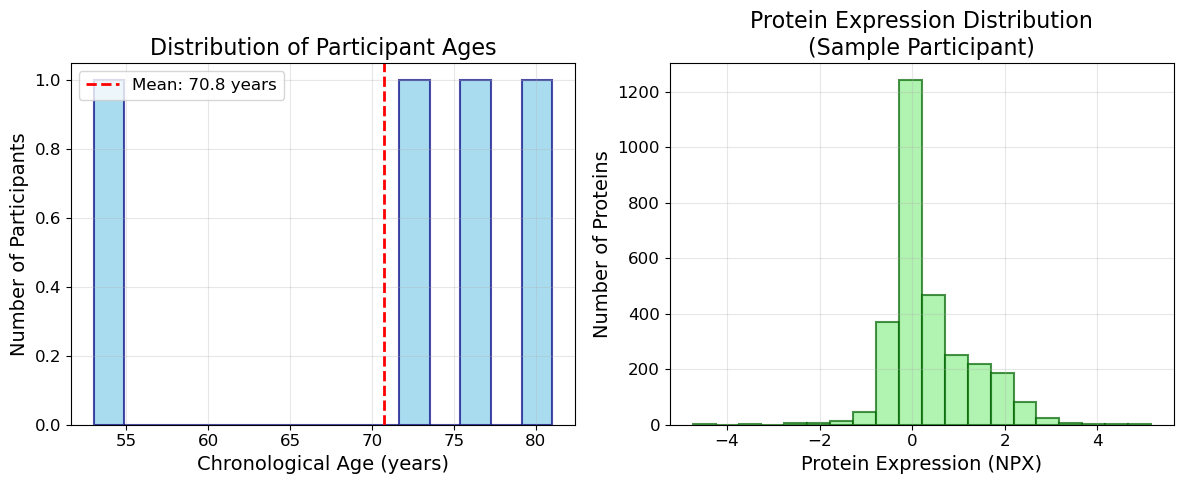

💡 NPX = Normalized Protein eXpression - log2-scaled protein abundance


In [9]:
# Create a beautiful age distribution plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Age histogram
ax1.hist(age_data['age'], bins=15, alpha=0.7, color='skyblue', edgecolor='navy', linewidth=1.5)
ax1.axvline(age_data['age'].mean(), color='red', linestyle='--', linewidth=2, 
           label=f'Mean: {age_data["age"].mean():.1f} years')
ax1.set_xlabel('Chronological Age (years)')
ax1.set_ylabel('Number of Participants')
ax1.set_title('Distribution of Participant Ages')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Protein measurement distribution for one participant
sample_participant = protein_data[protein_data['patient_id'] == protein_data['patient_id'].iloc[0]]
ax2.hist(sample_participant['NPX'], bins=20, alpha=0.7, color='lightgreen', 
         edgecolor='darkgreen', linewidth=1.5)
ax2.set_xlabel('Protein Expression (NPX)')
ax2.set_ylabel('Number of Proteins')
ax2.set_title('Protein Expression Distribution\n(Sample Participant)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("💡 NPX = Normalized Protein eXpression - log2-scaled protein abundance")

## 🔮 Step 4: Predicting Biological Ages *per se*

Now, simply use the `.predict_age` method shared by all clocks.
All sections past this one are visualizations and do not represent any unique `proteoclock` functionality. As long as you've cleared this part with no errors, everything works as intended.

In [10]:
print("🔮 PREDICTING BIOLOGICAL AGES...")
print("="*40)

scaling_mode = 'standard'
# ...or 'minmax', or simply None

# Predict with each clock
print("⚡ Kuo clock (Gompertz model)...")
kuo_predictions = kuo_clock.predict_age(protein_data, age_data, scaling=scaling_mode)

print("🫀 Goeminne liver-specific clock...")
goem_liver_predictions = goem_liver.predict_age(protein_data, scaling=scaling_mode)

print("💀 Goeminne mortality-focused clock...")
goem_mortality_predictions = goem_mortality.predict_age(protein_data, scaling=scaling_mode)

print("🧠 Galkin deep learning clock...")
galkin_predictions = galkin_clock.predict_age(protein_data)

print("\n✨ All predictions completed!")

# Combine everything into a results dataframe
results_df = age_data.copy()
results_df.index = results_df['patient_id']
results_df = results_df.drop(['patient_id'], axis = 1)
results_df['kuo_predicted'] = kuo_predictions
results_df['goem_liver_predicted'] = goem_liver_predictions
results_df['goem_mortality_predicted'] = goem_mortality_predictions
results_df['galkin_predicted'] = galkin_predictions

print("\n📊 PREDICTION RESULTS:")
display(results_df.head())

🔮 PREDICTING BIOLOGICAL AGES...
⚡ Kuo clock (Gompertz model)...
🫀 Goeminne liver-specific clock...
💀 Goeminne mortality-focused clock...
🧠 Galkin deep learning clock...

✨ All predictions completed!

📊 PREDICTION RESULTS:


,age,kuo_predicted,goem_liver_predicted,goem_mortality_predicted,galkin_predicted
patient_id,,,,,
sample_1,53,44.231116,47.819564,52.096270,56.810249
sample_2,81,68.306219,58.225695,77.015442,75.638710
sample_3,76,69.412130,63.471896,75.709191,68.915710
sample_4,73,46.874874,60.906852,48.890537,71.904274


## 📈 Step 5: Analyzing Clock Performance

See how well each clock performs:

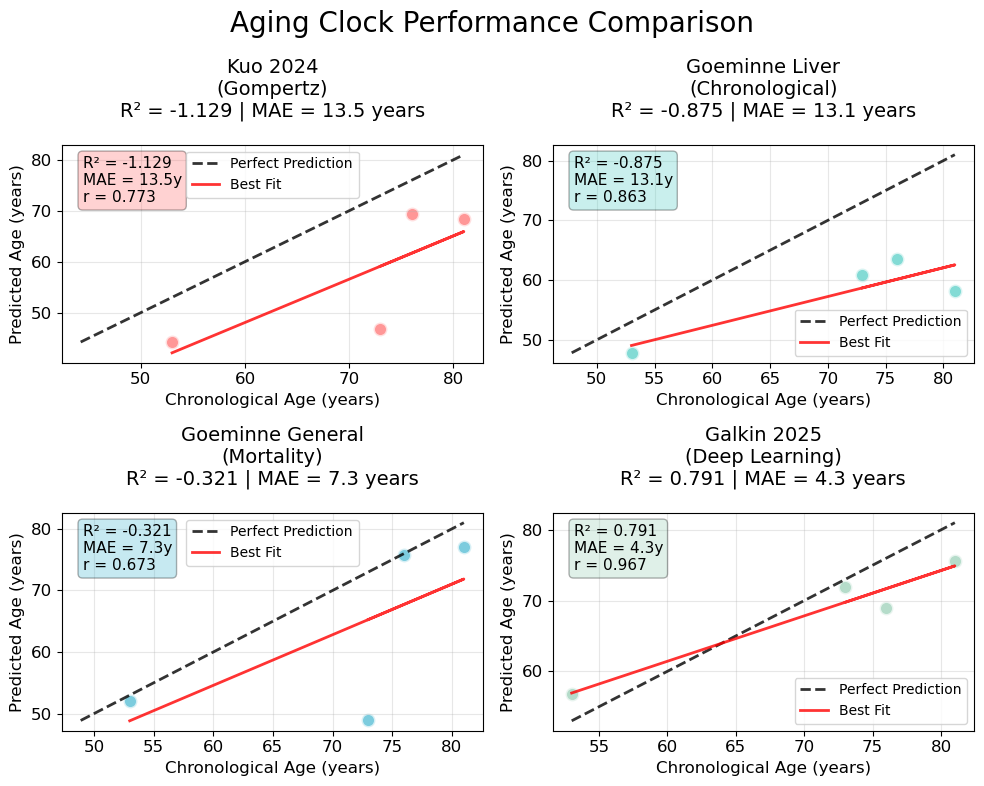


📊 PERFORMANCE SUMMARY:


,Clock,R²,MAE,Correlation
0,Kuo 2024 (Gompertz),-1.129,13.544,0.773
1,Goeminne Liver (Chronological),-0.875,13.144,0.863
2,Goeminne General (Mortality),-0.321,7.322,0.673
3,Galkin 2025 (Deep Learning),0.791,4.338,0.967


In [12]:
# Calculate performance metrics
clocks = {
    'Kuo 2024\n(Gompertz)': 'kuo_predicted',
    'Goeminne Liver\n(Chronological)': 'goem_liver_predicted', 
    'Goeminne General\n(Mortality)': 'goem_mortality_predicted',
    'Galkin 2025\n(Deep Learning)': 'galkin_predicted'
}

# Create a comprehensive performance visualization
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.ravel()

colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
performance_stats = []

for i, (clock_name, pred_col) in enumerate(clocks.items()):
    ax = axes[i]
    
    # Scatter plot with regression line
    ax.scatter(results_df['age'], results_df[pred_col], 
              alpha=0.7, s=100, color=colors[i], edgecolors='white', linewidth=2)
    
    # Perfect prediction line
    min_age = min(results_df['age'].min(), results_df[pred_col].min())
    max_age = max(results_df['age'].max(), results_df[pred_col].max())
    ax.plot([min_age, max_age], [min_age, max_age], 'k--', alpha=0.8, linewidth=2, 
            label='Perfect Prediction')
    
    # Regression line
    z = np.polyfit(results_df['age'], results_df[pred_col], 1)
    p = np.poly1d(z)
    ax.plot(results_df['age'], p(results_df['age']), color='red', linewidth=2, 
            alpha=0.8, label='Best Fit')
    
    # Calculate metrics
    r2 = r2_score(results_df['age'], results_df[pred_col])
    mae = mean_absolute_error(results_df['age'], results_df[pred_col])
    correlation = np.corrcoef(results_df['age'], results_df[pred_col])[0,1]
    
    performance_stats.append({
        'Clock': clock_name.replace('\n', ' '),
        'R²': r2,
        'MAE': mae,
        'Correlation': correlation
    })
    
    # Styling
    ax.set_xlabel('Chronological Age (years)', fontsize=12)
    ax.set_ylabel('Predicted Age (years)', fontsize=12)
    ax.set_title(f'{clock_name}\nR² = {r2:.3f} | MAE = {mae:.1f} years', 
                 fontsize=14, pad=20)
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=10)
    
    # Add performance box
    textstr = f'R² = {r2:.3f}\nMAE = {mae:.1f}y\nr = {correlation:.3f}'
    props = dict(boxstyle='round', facecolor=colors[i], alpha=0.3)
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=11,
            verticalalignment='top', bbox=props)

plt.suptitle('Aging Clock Performance Comparison', fontsize=20, y=0.98)
plt.tight_layout()
plt.show()

# Performance summary table
perf_df = pd.DataFrame(performance_stats)
print("\n📊 PERFORMANCE SUMMARY:")
display(perf_df.round(3))

## ⚡ Step 6: Understanding Age Acceleration

**Age acceleration** = Predicted age - Chronological age
- **Positive values**: "Fast aging" - biological age > chronological age
- **Negative values**: "Slow aging" - biological age < chronological age
- **Zero**: Perfect match between biological and chronological age# Calculate age acceleration for each clock

⚡ CALCULATING AGE ACCELERATION...


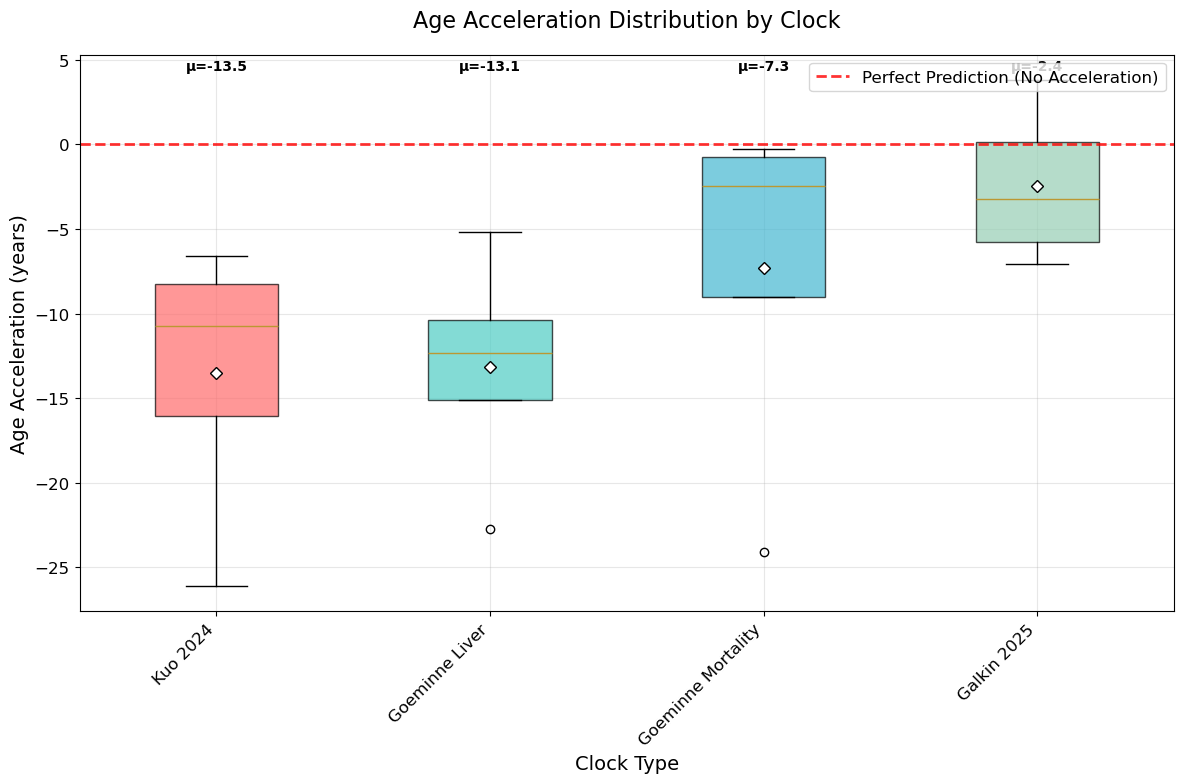


📈 AGE ACCELERATION STATISTICS:


,Clock,Mean Acceleration,Std Acceleration,Min Acceleration,Max Acceleration
0,Kuo 2024,-13.54,8.76,-26.13,-6.59
1,Goeminne Liver,-13.14,7.25,-22.77,-5.18
2,Goeminne Mortality,-7.32,11.31,-24.11,-0.29
3,Galkin 2025,-2.43,4.86,-7.08,3.81


In [10]:
# Calculate age acceleration for each clock
print("⚡ CALCULATING AGE ACCELERATION...")
print("="*40)

for clock_name, pred_col in clocks.items():
    accel_col = pred_col.replace('predicted', 'accel')
    results_df[accel_col] = results_df[pred_col] - results_df['age']

# Create age acceleration comparison
accel_cols = ['kuo_accel', 'goem_liver_accel', 'goem_mortality_accel', 'galkin_accel']
accel_names = ['Kuo 2024', 'Goeminne Liver', 'Goeminne Mortality', 'Galkin 2025']

# Create boxplot visualization
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Prepare data for boxplot
box_data = pd.DataFrame({name: results_df[col] for name, col in zip(accel_names, accel_cols)})
box_plot = ax.boxplot([box_data[name] for name in accel_names], 
                      labels=accel_names, patch_artist=True,
                      showmeans=True, meanprops=dict(marker='D', markerfacecolor='white', markeredgecolor='black'))

# Color the boxes
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

# Style the plot
ax.axhline(y=0, color='red', linestyle='--', alpha=0.8, linewidth=2, 
           label='Perfect Prediction (No Acceleration)')
ax.set_xticklabels(accel_names, rotation=45, ha='right')
ax.set_ylabel('Age Acceleration (years)', fontsize=14)
ax.set_xlabel('Clock Type', fontsize=14)
ax.set_title('Age Acceleration Distribution by Clock', fontsize=16, pad=20)
ax.grid(True, alpha=0.3)
ax.legend(loc='upper right')

# Add some statistics annotations
for i, (name, col) in enumerate(zip(accel_names, accel_cols)):
    mean_val = results_df[col].mean()
    ax.text(i+1, ax.get_ylim()[1]*0.95, f'μ={mean_val:.1f}', 
            ha='center', va='top', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# Statistics summary
print("\n📈 AGE ACCELERATION STATISTICS:")
accel_stats = pd.DataFrame({
    'Clock': accel_names,
    'Mean Acceleration': [results_df[col].mean() for col in accel_cols],
    'Std Acceleration': [results_df[col].std() for col in accel_cols],
    'Min Acceleration': [results_df[col].min() for col in accel_cols],
    'Max Acceleration': [results_df[col].max() for col in accel_cols]
})
display(accel_stats.round(2))

## 🎓 Congratulations!
You now know how to use `proteoclock` for age predictions with different aging clocks!